In [1]:
using QuBase
using QuDynamics
using PyPlot;


Use "Base.:(==)" instead.
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in scale(::Float64, ::Array{Float64,2}) at ./deprecated.jl:50
 in scale(::Float64, ::QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}) at /home/nicolas/.julia/v0.5/QuBase/src/arrays/arraymath.jl:99
 in *(::Float64, ::QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}) at /home/nicolas/.julia/v0.5/QuBase/src/arrays/arraymath.jl:106
 in include_from_node1(::String) at ./loading.jl:488 (repeats 3 times)
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:415
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/nicolas/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/nicolas/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading /home/nicolas/.julia/v0.5/QuBase/src/arrays/spinops.jl, i

El operador tensor (como lo dice su nombre) hace un cálculo tensorial. La función statevec genera un arreglo de Float64 donde el primer valor en el argumento es la posición del 1 y FiniteBasis(N) genera una base de dimensión N. Así, tendremos un arreglo de dimensión N con entrada distinta de cero únicamente en la posición dada con el primer valor del argumento. 

In [2]:
tensor(statevec(1, FiniteBasis(N)), statevec(2, FiniteBasis(2)))

LoadError: LoadError: UndefVarError: N not defined
while loading In[2], in expression starting on line 1

In [3]:
ω_0 = 2*π       #Cavity Frecuency
ω_A = 2*π       #Atom Frecuency
g = 2*π*0.05    #Coupling Strength
κ = 0.05        #Cavity Dissipation Rate
γ = 0.15        #Atom Dissipation Rate
N = 5           #Number of Cavity Fock States

# initial state
# We take it as the tensor product of a orthogonal basis. With the calculation below we get 
# a 4-element QuVector in QuBase.FiniteBasis{QuBase.Orthonormal}

ψ_initial = complex(tensor(statevec(1, FiniteBasis(N)), statevec(2, FiniteBasis(2))))

# start with an excited atom

time = linspace(0, 30, 150) # Time 

;

In [4]:
# We translate the above equation, The Hamiltonian, with and without the RWA, as described below. 

Qu_I_C = QuArray(eye(N)) #Quantum Array with identity matrix of size N. We use N because of Fock states. 

Qu_I_A = QuArray(eye(2)) #Quantum Array with identity matrix of size 2. 

σ_plus  = tensor(lowerop(N), Qu_I_A) #Atomic transition operator. ## Aquí se hace un producto tensorial de 2 M de 2x2. 

low_operator = tensor(Qu_I_C, lowerop(2)) #Lowering Operator

####### 

# Hay que notar que en la siguiente definción del Hamiltoniano no se utiliza el término sigma_3. Supongo que 
# se debe a que se supuso que se empieza con un átomo excitado. 
# Se necesitan matrices de 4x4 porque nuestro estado inicial psi0 es un arreglo de 4 elementos. 

#######

use_rwa = true

# The instruction below will take into account both scenarious: with and without RWA. 

if use_rwa
    # using RWA
    H = ω_0 * (σ_plus)' * (σ_plus) + (ω_A * (low_operator)' * (low_operator)) + (g * ((σ_plus)' * (low_operator) + (σ_plus) * (low_operator)'))
else
    H = ω_0 * (σ_plus)' * (σ_plus) + (ω_A * (low_operator)' * (low_operator)) + (g * ((σ_plus)' + (σ_plus)) * ((low_operator) + (low_operator)'))
end

H = full(H) # Output = Complete Hamiltonian
;

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in scale(::Float64, ::SparseMatrixCSC{Float64,Int64}) at ./deprecated.jl:50
 in scale(::Float64, ::QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,SparseMatrixCSC{Float64,Int64}}) at /home/nicolas/.julia/v0.5/QuBase/src/arrays/arraymath.jl:99
 in *(::Float64, ::QuBase.CTranspose{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,SparseMatrixCSC{Float64,Int64}}}, ::QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,SparseMatrixCSC{Float64,Int64}}) at ./operators.jl:138
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/nicolas/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/nicolas/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[4], in expression starting on line 25


In [5]:
# collapse operators

collapse_operator_list = Array(QuBase.AbstractQuMatrix, 0) #Arreglo cuántico al cual se le meterán datos. 
temperature = 0.0 # zero temperature
#Recordamos lo que ya antes fue mencionado.

####    κ = 0.05        # cavity dissipation rate
####   γ = 0.15        # atom dissipation rate

rate_1 = κ * (1 + temperature)

 if rate_1 > 0.0
    push!(collapse_operator_list, full(sqrt(rate_1) * (σ_plus))) #Multiplica el operador de trans atómica y la raíz de rate_1
 end

rate = κ * temperature #se define otro rate el cual también se añade al arreglo cuántico. 
 if rate > 0.0
    push!(collapse_operator_list, full(sqrt(rate) * (σ_plus)')) #Se multiplica ahora por el otro op de trans 
 end

#Vemos que rate_1 y rate son iguales debido a la nula temperatura

 rate = γ #Aquí γ se asocia al átomo, ya que es su razón de disipasión.
 if rate > 0.0
    push!(collapse_operator_list, full(sqrt(rate) * (low_operator)))
 end
;

In [6]:
lindblad = QuDynamics.lindblad_op(H, collapse_operator_list);

In [7]:
quexpmv = QuPropagator(H, collapse_operator_list, ψ_initial*ψ_initial', time, QuExpmV())

Summarizing the system :
Equation type : QuDynamics.QuLindbladMasterEq{1,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuBase.AbstractQuArray{B<:QuBase.AbstractBasis,T,2}}
Size of the Lindblad operator of the system : (100,100)
Size of the Hamiltonian of the system : (10,10)
Number of collapse operators : 2
Size of the Density matrix : (10,10)
Time steps used : linspace(0.0,30.0,150)
Solver used : QuDynamics.QuExpmV(Dict{Symbol,Any}())


In [8]:
arreglo = []

push!(arreglo, coeffs(vec(ψ_initial*(ψ_initial)'))) #Añadiéndole este término logramos que las dimensiones 
# de tiempo y arreglo sean iguales, es decir, 150. 

for (t, psi) in quexpmv
    push!(arreglo, coeffs(vec(psi)))
end 

jjj = []

for i in 1:length(arreglo)
    for j in 1:length(arreglo[i])
        #@show i
        #@show j
      #@show real(arreglo[i][j])
    end
end

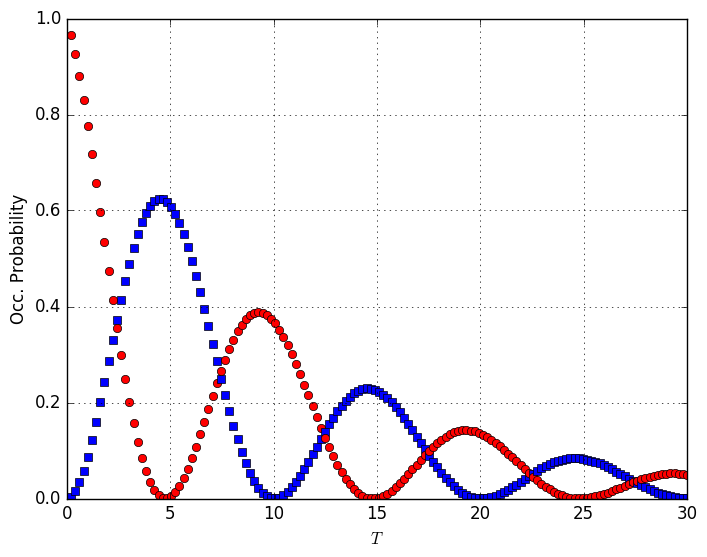

In [9]:
for (t,psi) in quexpmv
    plot(t, (trace(psi*(σ_plus)'*(σ_plus))), "bs")
    plot(t, (trace(psi*(low_operator)'*(low_operator))), "ro")
    
end


grid("on")

xlabel(L"T")
ylabel("Occ. Probability")
legend(loc="upper right",fancybox="true")

## Cambiando g

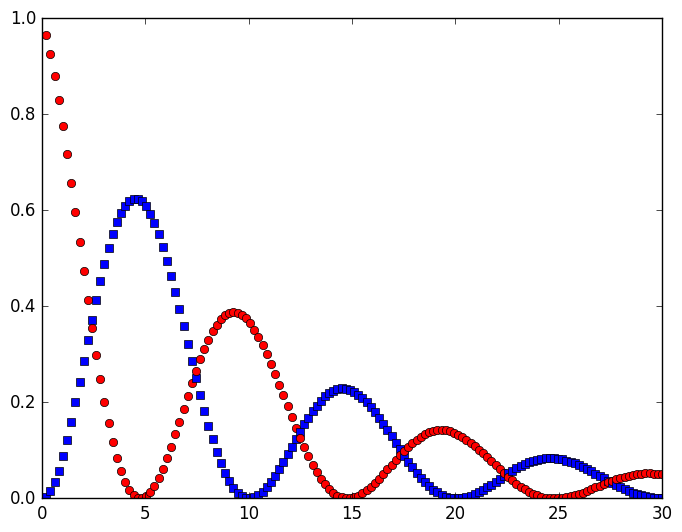

In [10]:
g_vec = linspace(0,30,150)
 H_g = ω_0 * (σ_plus)' * (σ_plus) + (ω_A * (low_operator)' * (low_operator)) + (g * ((σ_plus)' * (low_operator) + (σ_plus) * (low_operator)'))
H_coupling = [H_g for g in g_vec]

expm = [QuPropagator(H_coupling[i], collapse_operator_list, ψ_initial*ψ_initial', g_vec, QuExpmV()) for i in 1:length(H_coupling)]

for (g_vec,psi) in expm[150]
    plot(g_vec, (trace(psi*(σ_plus)'*(σ_plus))), "bs")
    plot(g_vec, (trace(psi*(low_operator)'*(low_operator))), "ro")
    
end

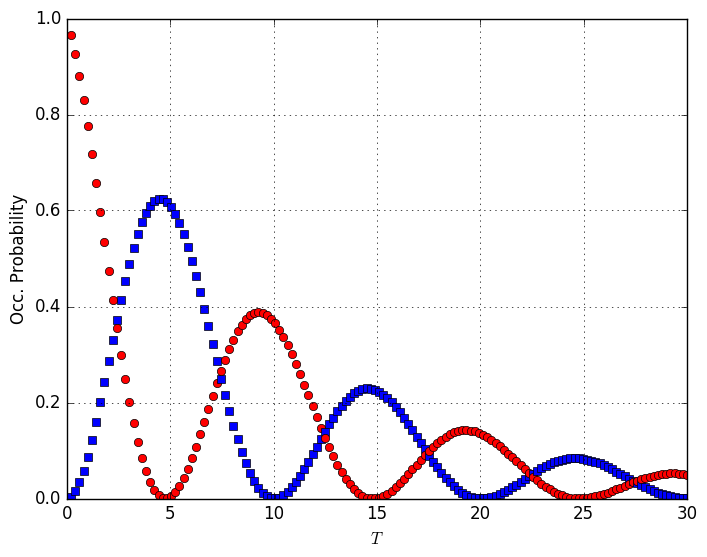

In [12]:
quexpmv_2 = QuPropagator(H, collapse_operator_list, ψ_initial*ψ_initial', time, QuExpmV())




for (t,psi) in quexpmv
    plot(t, (trace(psi*(σ_plus)'*(σ_plus))), "bs")
    plot(t, (trace(psi*(low_operator)'*(low_operator))), "ro")
    
end


grid("on")

xlabel(L"T")
ylabel("Occ. Probability")
legend(loc="upper right",fancybox="true")

In [13]:
# collapse operators

collapse_operator_list_2 = Array(QuBase.AbstractQuMatrix, 0) #Arreglo cuántico al cual se le meterán datos. 
temperature = 0.0 # zero temperature
#Recordamos lo que ya antes fue mencionado.

####    κ = 0.05        # cavity dissipation rate
####   γ = 0.15        # atom dissipation rate

#rate_1 = κ * (1 + temperature)

# if rate_1 > 0.0
#    push!(collapse_operator_list, full(sqrt(rate_1) * (σ_plus))) #Multiplica el operador de trans atómica y la raíz de rate_1
# end

#rate = κ * temperature #se define otro rate el cual también se añade al arreglo cuántico. 

# if rate > 0.0
#    push!(collapse_operator_list, full(sqrt(rate) * (σ_plus)')) #Se multiplica ahora por el otro op de trans 
# end

#Vemos que rate_1 y rate son iguales debido a la nula temperatura

 
rate = γ #Aquí γ se asocia al átomo, ya que es su razón de disipasión.
 if rate > 0.0
    push!(collapse_operator_list, full(sqrt(rate) * (low_operator)))
 end
;

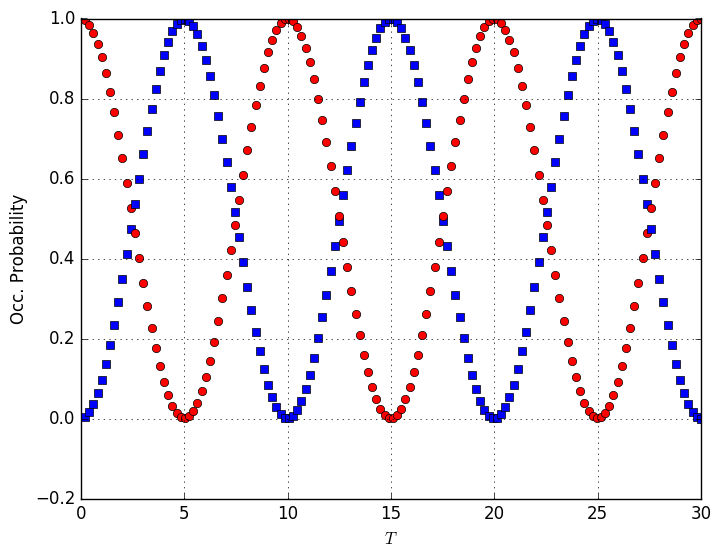

In [14]:
quexpmv_3 = QuPropagator(H, collapse_operator_list_2, ψ_initial*ψ_initial', time, QuExpmV())




for (t,psi) in quexpmv_3
    plot(t, (trace(psi*(σ_plus)'*(σ_plus))), "bs")
    plot(t, (trace(psi*(low_operator)'*(low_operator))), "ro")
    
end


grid("on")

xlabel(L"T")
ylabel("Occ. Probability")
legend(loc="upper right",fancybox="true")